In [1]:
import numpy as np
import pandas as pd
import sympy as sy

# Try importing torch, but don't fail if it's not available
try:
    import torch
    TORCH_AVAILABLE = True
    print(f"PyTorch {torch.__version__} is available")
except ImportError:
    TORCH_AVAILABLE = False
    print("Warning: PyTorch is not installed. Using numpy/scipy for diagonalization.")
    torch = None

import ujson as uj

from copy import deepcopy
from functools import partial
from pathlib import Path

from sympy.physics.wigner import wigner_3j, wigner_6j
from numpy import linalg as LA
from IPython.display import Latex, display
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.collections import LineCollection
%matplotlib inline
import seaborn as sns

from scipy.optimize import least_squares
from scipy.stats import norm

import Energy_Levels as EL
from Energy_Levels import MoleculeLevels
from Energy_Levels import (
    branching_ratios,
    Calculate_TDMs,
    Calculate_TDM_evecs,
    Calculate_forbidden_TDM_evecs,
    Calculate_forbidden_TDMs,
)

print("All imports successful!")

# sns.set()
# sns.set_palette('bright')
# np.set_printoptions(precision=9, suppress=True)
# from tabulate import tabulate

PyTorch 2.3.0 is available
All imports successful!


In [2]:
# Torch device configuration and GPU-ready diagonalization hooks
# Only configure torch if it's available
if TORCH_AVAILABLE:
    try:
        TORCH_DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using torch device: {TORCH_DEVICE}")
    except Exception as e:
        print(f"Warning: Could not configure torch device: {e}")
        TORCH_AVAILABLE = False
else:
    TORCH_DEVICE = None
    print("Torch not available, using numpy/scipy for diagonalization")

# Store original functions
if not hasattr(EL, "diagonalize_cpu"):
    EL.diagonalize_cpu = EL.diagonalize
    EL.diagonalize_batch_cpu = EL.diagonalize_batch

# Patch the diagonalize function in the Energy_Levels module
# This ensures internal calls to diagonalize() use our patched version
def diagonalize_with_device(matrix, method="torch", order=False, Normalize=False, round=10):
    """GPU/CPU-aware diagonalization with proper tensor handling."""
    if method == "torch" and TORCH_AVAILABLE:
        try:
            tensor = torch.from_numpy(matrix).to(TORCH_DEVICE)
            w, v = torch.linalg.eigh(tensor)
            # Use detach() to ensure we can convert to numpy even if requires_grad=True
            evals = np.round(w.detach().cpu().numpy(), round)
            evecs = np.round(v.detach().cpu().numpy().T, round)
            if order:
                idx_order = np.argsort(evals)
                evecs = evecs[idx_order, :]
                evals = evals[idx_order]
            return evals, evecs
        except Exception as e:
            print(f"Warning: Torch diagonalization failed: {e}")
            print("Falling back to numpy...")
            method = "numpy"
    # Fallback to original function for non-torch methods
    return EL.diagonalize_cpu(matrix, method=method, order=order, Normalize=Normalize, round=round)


def diagonalize_batch_with_device(matrix_array, method="torch", round=10):
    """GPU/CPU-aware batch diagonalization with proper tensor handling."""
    if method == "torch" and TORCH_AVAILABLE:
        try:
            tensors = torch.from_numpy(matrix_array).to(TORCH_DEVICE)
            w, v = torch.linalg.eigh(tensors)
            evals = np.round(w.detach().cpu().numpy(), round)
            evecs = np.round(v.detach().cpu().numpy().transpose(0, 2, 1), round)
            return evals, evecs
        except Exception as e:
            print(f"Warning: Torch batch diagonalization failed: {e}")
            print("Falling back to numpy...")
            method = "numpy"
    # Fallback to original function for non-torch methods
    return EL.diagonalize_batch_cpu(matrix_array, method=method, round=round)


# Patch the functions in the module namespace
# This replaces the function references so internal calls use the patched version
EL.diagonalize = diagonalize_with_device
EL.diagonalize_batch = diagonalize_batch_with_device
if TORCH_AVAILABLE:
    EL.TORCH_DEVICE = TORCH_DEVICE

print("Diagonalization functions configured successfully.")
print(f"Default method: {'torch' if TORCH_AVAILABLE else 'numpy'}")


Using torch device: cpu
Diagonalization functions configured successfully.
Default method: torch


In [3]:
X010_173 = MoleculeLevels.initialize_state(
    "YbOH",
    "173",
    "X010",
    [1, 2],
    M_values="all",
    I=[5 / 2, 1 / 2],
    S=1 / 2,
    round=8,
    P_values=[1 / 2, 3 / 2],
)

BASE_PARAMETERS = deepcopy(X010_173.parameters)
FIT_PARAMETER_NAMES = [
    "Be",
    "Gamma_SR",
    "Gamma_Prime",
    "bFYb",
    "cYb",
    "bFH",
    "cH",
    "e2Qq0",
    "q_lD",
    "p_lD",
    "muE",
    "g_S_eff",
]
PARAM_PRIORS = {key: BASE_PARAMETERS[key] for key in FIT_PARAMETER_NAMES}


def _default_bound(value, frac=0.2, floor=1e-6):
    span = max(abs(value) * frac, floor)
    return value - span, value + span


FIT_PARAMETER_BOUNDS = {key: _default_bound(PARAM_PRIORS[key]) for key in FIT_PARAMETER_NAMES}

print(f"Loaded {X010_173.iso_state} with {len(FIT_PARAMETER_NAMES)} fit parameters tracked.")

Loaded 173X010 with 12 fit parameters tracked.


In [4]:
# --- Synthetic "experimental" peak generator for this repo (windowed & sparse) ---
# Run this AFTER you have X010_173 initialized.
# Goal: for EACH spectrum, produce 5–10 observed peaks between 300 and 400 MHz.

import numpy as np
import pandas as pd

# ------------------- helpers -------------------
def _to_numpy_1d(x):
    """Convert torch/numpy/list to a 1D float numpy array."""
    try:
        import torch
        if isinstance(x, torch.Tensor):
            return x.detach().cpu().numpy().astype(float).ravel()
    except Exception:
        pass
    return np.asarray(x, dtype=float).ravel()

def get_evals(state, Ez, Bz, method="torch"):
    """
    Robustly get eigenvalues from MoleculeLevels regardless of return style.
    Uses set_attr=True then reads state.evals if needed.
    """
    out = state.eigensystem(Ez, Bz, order=True, method=method, set_attr=True)
    if out is not None:
        evals = out[0]
    else:
        evals = getattr(state, "evals", None)
        if evals is None:
            raise RuntimeError("Couldn't find eigenvalues. state.eigensystem() didn't return and state.evals not set.")
    evals = _to_numpy_1d(evals)
    if evals.size < 2:
        raise RuntimeError(f"Too few eigenvalues ({evals.size}). Basis/truncation may be too small.")
    return evals

def predict_lines_from_levels(evals,
                             n_levels=120,
                             fmin=300.0,
                             fmax=400.0,
                             max_lines=50000,
                             seed=0):
    """
    Candidate transition frequencies from pairwise differences of the lowest n_levels energies.
    NOT enforcing selection rules (pipeline testing only).

    Returns only lines within [fmin, fmax] MHz (no auto-expansion).
    """
    rng = np.random.default_rng(seed)

    e = np.sort(_to_numpy_1d(evals))
    n = min(int(n_levels), e.size)
    if n < 2:
        return np.array([], dtype=float)
    e = e[:n]

    # Positive pairwise differences: e[j] - e[i] for j>i
    diffs = (e[None, :] - e[:, None])[np.triu_indices(n, k=1)]
    diffs = diffs[(diffs >= fmin) & (diffs <= fmax)]

    if diffs.size == 0:
        return np.array([], dtype=float)

    diffs = np.unique(np.round(np.sort(diffs), 6))

    # If too many, subsample to max_lines for speed
    if diffs.size > max_lines:
        idx = rng.choice(diffs.size, size=max_lines, replace=False)
        diffs = np.sort(diffs[idx])

    return diffs.astype(float)

def make_fake_experiment_in_window(lines,
                                   nu_min=300.0,
                                   nu_max=400.0,
                                   n_keep_min=5,
                                   n_keep_max=10,
                                   sigma_MHz=0.25,
                                   spurious=1,
                                   seed=0):
    """
    Create sparse, unassigned observed peaks in [nu_min, nu_max] MHz.

    - Picks a random number of peaks between n_keep_min and n_keep_max from the candidate lines.
    - If not enough candidate lines exist, fills remaining peaks uniformly in-window (spurious).
    - Adds Gaussian jitter sigma_MHz to mimic centroid uncertainty.
    - Adds extra spurious peaks (optional) uniformly in-window.
    """
    rng = np.random.default_rng(seed)
    lines = _to_numpy_1d(lines)

    # Ensure windowing (should already be windowed, but keep safe)
    inwin = lines[(lines >= nu_min) & (lines <= nu_max)]
    inwin = np.unique(np.round(np.sort(inwin), 6))

    n_target = int(rng.integers(int(n_keep_min), int(n_keep_max) + 1))

    if inwin.size >= n_target:
        idx = rng.choice(inwin.size, size=n_target, replace=False)
        obs = np.sort(inwin[idx])
    else:
        obs = inwin.copy()
        n_missing = n_target - obs.size
        fill = rng.uniform(nu_min, nu_max, size=n_missing)
        obs = np.sort(np.concatenate([obs, fill]))

    # Add measurement jitter and clip to window
    obs = obs + rng.normal(0.0, sigma_MHz, size=obs.size)
    obs = np.clip(obs, nu_min, nu_max)

    # Add extra spurious peaks (optional)
    if spurious and int(spurious) > 0:
        spur = rng.uniform(nu_min, nu_max, size=int(spurious))
        obs = np.sort(np.concatenate([obs, spur]))

    return np.sort(obs)

def generate_synthetic_peaks_csv_windowed(state,
                                         conditions,
                                         output_csv="synthetic_peaks.csv",
                                         method="torch",
                                         # window constraints
                                         window_min=300.0,
                                         window_max=400.0,
                                         # eigenlevel sampling
                                         n_levels_start=120,
                                         n_levels_max=600,
                                         # observed sparsity
                                         n_keep_min=5,
                                         n_keep_max=10,
                                         sigma_MHz=0.25,
                                         spurious=1,
                                         seed_base=0,
                                         verbose=True):
    """
    Generate a multi-spectrum unassigned peak CSV with 5–10 peaks per spectrum
    in a specified frequency window [window_min, window_max] MHz.
    """
    rows = []

    for idx, (spec_id, Ez, Bz) in enumerate(conditions):
        evals = get_evals(state, Ez, Bz, method=method)

        # Try increasing n_levels until we get some lines in the window
        lines = np.array([], dtype=float)
        n_levels = int(n_levels_start)

        while lines.size == 0 and n_levels <= int(n_levels_max):
            lines = predict_lines_from_levels(
                evals,
                n_levels=n_levels,
                fmin=window_min,
                fmax=window_max,
                max_lines=50000,
                seed=seed_base + 100 + idx,
            )
            n_levels = int(np.ceil(n_levels * 1.5))

        # If still none, widen the window slightly (still centered around requested region)
        if lines.size == 0:
            lines = predict_lines_from_levels(
                evals,
                n_levels=min(int(n_levels_max), evals.size),
                fmin=window_min - 50.0,
                fmax=window_max + 50.0,
                max_lines=50000,
                seed=seed_base + 200 + idx,
            )

        if lines.size == 0:
            raise RuntimeError(
                f"[{spec_id}] No candidate lines found near {window_min}-{window_max} MHz "
                f"(even after widening). Try increasing n_levels_max or widening the window."
            )

        peaks = make_fake_experiment_in_window(
            lines,
            nu_min=window_min,
            nu_max=window_max,
            n_keep_min=n_keep_min,
            n_keep_max=n_keep_max,
            sigma_MHz=sigma_MHz,
            spurious=spurious,
            seed=seed_base + 300 + idx,
        )

        if verbose:
            print(f"{spec_id}: Ez={Ez} V/cm, Bz={Bz} G | evals={evals.size} | "
                  f"cand_lines_in_window={lines.size} | peaks_written={peaks.size} | "
                  f"window=[{window_min},{window_max}] MHz")

        for nu in peaks:
            rows.append({
                "spectrum_id": spec_id,
                "Ez_V_per_cm": float(Ez),
                "Bz_G": float(Bz),
                "nu_obs_MHz": float(nu),
                "sigma_MHz": float(sigma_MHz),
            })

    df = pd.DataFrame(rows).sort_values(["spectrum_id", "nu_obs_MHz"]).reset_index(drop=True)
    df.to_csv(output_csv, index=False)
    return df

# ------------------- Example usage -------------------
spectra_conditions = [
    ("spec0", 0.0, 0.0),
    ("spec1", 20.0, 5.0),
    ("spec2", 40.0, 5.0),
    ("spec3", 60.0, 10.0),
]

df = generate_synthetic_peaks_csv_windowed(
    X010_173,
    spectra_conditions,
    output_csv="synthetic_peaks.csv",
    method="torch",
    window_min=300.0,
    window_max=400.0,
    n_levels_start=120,
    n_levels_max=600,
    n_keep_min=5,
    n_keep_max=10,
    sigma_MHz=0.25,
    spurious=1,          # set 0 for none
    seed_base=123,
    verbose=True,
)

df.head(20)
# File "synthetic_peaks.csv" now has ~5–10 peaks per spectrum in 300–400 MHz.


spec0: Ez=0.0 V/cm, Bz=0.0 G | evals=384 | cand_lines_in_window=12 | peaks_written=9 | window=[300.0,400.0] MHz
spec1: Ez=20.0 V/cm, Bz=5.0 G | evals=384 | cand_lines_in_window=727 | peaks_written=7 | window=[300.0,400.0] MHz
spec2: Ez=40.0 V/cm, Bz=5.0 G | evals=384 | cand_lines_in_window=709 | peaks_written=7 | window=[300.0,400.0] MHz
spec3: Ez=60.0 V/cm, Bz=10.0 G | evals=384 | cand_lines_in_window=626 | peaks_written=6 | window=[300.0,400.0] MHz


,spectrum_id,Ez_V_per_cm,Bz_G,nu_obs_MHz,sigma_MHz
0,spec0,0.0,0.0,333.376732,0.25
1,spec0,0.0,0.0,364.887204,0.25
2,spec0,0.0,0.0,365.364439,0.25
3,spec0,0.0,0.0,367.536199,0.25
4,spec0,0.0,0.0,383.535537,0.25
5,spec0,0.0,0.0,384.038642,0.25
6,spec0,0.0,0.0,385.990856,0.25
7,spec0,0.0,0.0,389.695853,0.25
8,spec0,0.0,0.0,391.957314,0.25
9,spec1,20.0,5.0,333.899341,0.25


In [5]:
def set_state_parameters(state, updates=None):
    if updates is None:
        updates = {}
    new_params = dict(state.parameters)
    new_params.update(updates)

    state.parameters = new_params
    state.library.parameters[state.iso_state] = new_params

    b = state.library.H_builders[state.iso_state]
    state.H_function, state.H_symbolic = b(
        state.q_numbers,
        params=new_params,
        M_values=state.M_values,
        precision=state.round,
    )

    state.eigensystem(0, 1e-8, order=True, method="torch", set_attr=True)
    state.generate_parities(state.evecs0)



def parameter_vector_to_dict(vector):
    return {name: value for name, value in zip(FIT_PARAMETER_NAMES, vector)}


def current_parameter_dict(state=None):
    source = state.parameters if state is not None else BASE_PARAMETERS
    return {name: source[name] for name in FIT_PARAMETER_NAMES}


def parameters_to_vector(params):
    return np.array([params[name] for name in FIT_PARAMETER_NAMES], dtype=float)

set_state_parameters(X010_173)
baseline_parameter_vector = parameters_to_vector(current_parameter_dict(X010_173))

In [18]:

# Frequency transform controls (matching the previous plotting convention)
FREQ_OFFSET = (106.089 - 97.58) * 2  # MHz
FREQ_SCALE = 0.5  # Divide by two for two-photon frequency conversion
FREQ_SHIFT = -90.0  # Additional shift applied after scaling


def model_frequency_transform(raw_freq):
    """Map raw transition frequency from the model to the experimental frequency axis."""
    return (raw_freq - FREQ_OFFSET) * FREQ_SCALE + FREQ_SHIFT


TRANSITION_INDEX_SET = None  # Replace with a list of indices to restrict transitions if desired
LASER_POLARIZATION = "orth"
PARITY_SIGN = 1
INTENSITY_THRESHOLD = None  # Set to a float to discard transitions with weaker intensity
EZ_FIELD = 40  # Update if the experimental conditions change
B_FIELD = 1e-8
RUN_OPTIMIZATION = False  # Set to True to launch least-squares fitting


In [19]:
def compute_model_transitions(
    state,
    Ez=EZ_FIELD,
    B=B_FIELD,
    indices=None,
    parity_sign=PARITY_SIGN,
    polarization=LASER_POLARIZATION,
):
    index_list = indices if indices is not None else TRANSITION_INDEX_SET
    if index_list is None:
        index_list = list(range(84))

    result = state.calculate_two_photon_spectrum(
        Ez,
        B,
        index_list,
        parity_sign=parity_sign,
        laser_polarization=polarization,
    )
    transitions = pd.DataFrame(result[1])

    if not transitions.empty:
        transitions["freq_model"] = transitions["freq"].apply(model_frequency_transform)
        if INTENSITY_THRESHOLD is not None:
            intensity_key = next(
                (key for key in ["intensity", "Intensity", "strength"] if key in transitions.columns),
                None,
            )
            if intensity_key is not None:
                transitions = transitions[transitions[intensity_key] >= INTENSITY_THRESHOLD].reset_index(drop=True)

    return transitions, result


def merge_predictions_with_experiment(predicted_df, experimental_df):
    if experimental_df.empty:
        predicted_df = predicted_df.copy()
        predicted_df["freq_obs"] = np.nan
        predicted_df["residual"] = np.nan
        predicted_df["weight"] = 1.0
        return predicted_df, pd.DataFrame(), predicted_df

    merge_cols = ["state index 0", "state index 1"]
    for col in ["M0", "M1"]:
        if col in experimental_df.columns and col in predicted_df.columns:
            merge_cols.append(col)

    merged = experimental_df.merge(predicted_df, how="left", on=merge_cols, suffixes=("_obs", "_model"))
    missing = merged[merged["freq_model"].isna()].copy()

    merged["freq_model"] = merged["freq_model"].astype(float)
    merged["residual"] = merged["freq_model"] - merged["freq_obs"]
    if "uncertainty" in merged.columns:
        weights = merged["uncertainty"].replace(0, np.nan).fillna(1.0)
    else:
        weights = pd.Series(1.0, index=merged.index)
    merged["weight"] = weights
    merged["weighted_residual"] = merged["residual"] / merged["weight"]

    matched = merged[merged["freq_model"].notna()].copy()
    return matched, missing, predicted_df


def summarize_fit(matched_df):
    if matched_df.empty:
        return {"rms": np.nan, "weighted_rms": np.nan, "n_points": 0}

    valid = np.isfinite(matched_df["residual"]) & np.isfinite(matched_df["weight"])
    if not valid.any():
        return {"rms": np.nan, "weighted_rms": np.nan, "n_points": 0}

    residuals = matched_df.loc[valid, "residual"].to_numpy()
    weights = matched_df.loc[valid, "weight"].to_numpy()
    rms = np.sqrt(np.mean(residuals**2))
    weighted_rms = np.sqrt(np.mean((residuals / weights) ** 2))
    return {"rms": rms, "weighted_rms": weighted_rms, "n_points": int(valid.sum())}

In [25]:
import importlib.util
from pathlib import Path

# ---------------------------
# Load molecule_parameters.py
# ---------------------------
MP_PATH = Path("molecule_parameters.py")  # if it's in the notebook folder
if not MP_PATH.exists():
    # if needed, point to your uploaded path or repo path:
    MP_PATH = Path("/mnt/data/molecule_parameters.py")

spec = importlib.util.spec_from_file_location("molecule_parameters", str(MP_PATH))
mp = importlib.util.module_from_spec(spec)
spec.loader.exec_module(mp)

# ---------------------------------------------------------
# Read the parameter MEANS for YbOH 173X010 (includes general)
# ---------------------------------------------------------
# This is the clean merged dict that your library likely expects:
params_173X010_mean = dict(mp.all_params["YbOH"]["173X010"])  # includes params_general
# alternatively: params_173X010_mean = {**mp.params_173X010, **mp.params_general}

# (Optional) apply these as the baseline parameters to your state
# Use only keys your state actually supports, to avoid KeyError downstream.
state_supported = set(current_parameter_dict(X010_173).keys())
params_173X010_mean_filtered = {k: v for k, v in params_173X010_mean.items() if k in state_supported}

set_state_parameters(X010_173, params_173X010_mean_filtered)

print("Loaded params for 173X010 (filtered to state):")
for k in sorted(params_173X010_mean_filtered.keys()):
    print(f"  {k:12s} = {params_173X010_mean_filtered[k]}")

# ---------------------------------------------------------
# Define / build UNCERTAINTIES (sigmas) -> you must supply these
# ---------------------------------------------------------
# Recommended: make a dict with 1-sigma uncertainties in the SAME UNITS as params.
# If you don't have them yet, start with fractional placeholders.
PARAM_SIGMA_173X010 = {
    # Fill these with your measured 1-sigma uncertainties (MHz etc.)
    # Examples (PLACEHOLDERS — replace with real numbers):
    # "Be": 0.5,
    # "Gamma_SR": 2.0,
    # "Gamma_Prime": 2.0,
    # "bFYb": 20.0,
    # "cYb": 10.0,
    # "e2Qq0": 20.0,
    # "q_lD": 0.5,
    # "p_lD": 0.5,
    # "muE": 0.01 * 0.503412,
    # "g_S_eff": 0.01,
}

# Fractional fallback if sigma not provided:
FRACTIONAL_SIGMA_FALLBACK = {
    "Be": 1e-4,
    "Gamma_SR": 2e-2,
    "Gamma_Prime": 2e-2,
    "bFYb": 5e-3,
    "cYb": 5e-2,
    "e2Qq0": 1e-2,
    "q_lD": 5e-2,
    "p_lD": 5e-2,
    "muE": 5e-3,
    "g_S_eff": 5e-3,
}

# Build priors: PARAM_PRIORS[name] = (mean, sigma)
PARAM_PRIORS = {}
for k, mu in params_173X010_mean_filtered.items():
    if k in PARAM_SIGMA_173X010:
        sig = float(PARAM_SIGMA_173X010[k])
    else:
        frac = float(FRACTIONAL_SIGMA_FALLBACK.get(k, 0.05))  # default 5% if unknown
        sig = abs(float(mu)) * frac if float(mu) != 0 else frac
    if sig <= 0:
        continue
    PARAM_PRIORS[k] = (float(mu), float(sig))

print("\nBuilt PARAM_PRIORS (mean, sigma):")
for k in sorted(PARAM_PRIORS.keys()):
    mu, sig = PARAM_PRIORS[k]
    print(f"  {k:12s} : mu={mu:.6g}, sigma={sig:.6g}")


Loaded params for 173X010 (filtered to state):
  Be           = 7334.130786908366
  Gamma_Prime  = 14.233846113382
  Gamma_SR     = -87.18714159785
  bFH          = 4.07
  bFYb         = -1880.9665339648823
  cH           = 3.49
  cYb          = -92.159499306238
  e2Qq0        = -3321.672553941406
  g_S_eff      = 2.07
  muE          = 1.08736992
  p_lD         = 12.766362031472
  q_lD         = 12.494150479608

Built PARAM_PRIORS (mean, sigma):
  Be           : mu=7334.13, sigma=0.733413
  Gamma_Prime  : mu=14.2338, sigma=0.284677
  Gamma_SR     : mu=-87.1871, sigma=1.74374
  bFH          : mu=4.07, sigma=0.2035
  bFYb         : mu=-1880.97, sigma=9.40483
  cH           : mu=3.49, sigma=0.1745
  cYb          : mu=-92.1595, sigma=4.60797
  e2Qq0        : mu=-3321.67, sigma=33.2167
  g_S_eff      : mu=2.07, sigma=0.01035
  muE          : mu=1.08737, sigma=0.00543685
  p_lD         : mu=12.7664, sigma=0.638318
  q_lD         : mu=12.4942, sigma=0.624708


In [ ]:
baseline_predicted_df, baseline_raw = compute_model_transitions(X010_173)
baseline_matched_df, baseline_missing_df, baseline_predicted_df = merge_predictions_with_experiment(
    baseline_predicted_df, observed_df
)
baseline_summary = summarize_fit(baseline_matched_df)

print("Baseline comparison summary:", baseline_summary)
if not baseline_missing_df.empty:
    print(f"Unmatched experimental assignments: {len(baseline_missing_df)}")


def weighted_residual_vector(param_vector):
    updates = parameter_vector_to_dict(param_vector)
    set_state_parameters(X010_173, updates)
    predicted_df, _ = compute_model_transitions(X010_173)
    matched_df, missing_df, _ = merge_predictions_with_experiment(predicted_df, observed_df)
    if matched_df.empty:
        raise ValueError(
            "No model transitions matched the experimental assignments. "
            "Adjust TRANSITION_INDEX_SET or check the assignments."
        )
    return matched_df["weighted_residual"].to_numpy()


optimization_result = None
fit_parameters = parameter_vector_to_dict(baseline_parameter_vector)
fit_predicted_df = baseline_predicted_df
fit_matched_df = baseline_matched_df
fit_missing_df = baseline_missing_df
fit_summary = baseline_summary

if RUN_OPTIMIZATION and not observed_df.empty:
    lower_bounds = np.array([FIT_PARAMETER_BOUNDS[name][0] for name in FIT_PARAMETER_NAMES])
    upper_bounds = np.array([FIT_PARAMETER_BOUNDS[name][1] for name in FIT_PARAMETER_NAMES])

    optimization_result = least_squares(
        weighted_residual_vector,
        x0=baseline_parameter_vector,
        bounds=(lower_bounds, upper_bounds),
        verbose=2,
    )
    fit_parameters = parameter_vector_to_dict(optimization_result.x)
    set_state_parameters(X010_173, fit_parameters)
    fit_predicted_df, _ = compute_model_transitions(X010_173)
    fit_matched_df, fit_missing_df, fit_predicted_df = merge_predictions_with_experiment(
        fit_predicted_df, observed_df
    )
    fit_summary = summarize_fit(fit_matched_df)
    print("Fit summary:", fit_summary)

fit_summary


In [ ]:
if not fit_matched_df.empty:
    display(fit_matched_df[["state index 0", "state index 1", "freq_obs", "freq_model", "residual"]].head())

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.errorbar(
        fit_matched_df["freq_obs"],
        fit_matched_df["freq_model"],
        yerr=fit_matched_df.get("uncertainty", pd.Series(0, index=fit_matched_df.index)),
        fmt="o",
        ms=6,
        alpha=0.7,
        label="Matched transitions",
    )
    lims = [
        min(fit_matched_df["freq_obs"].min(), fit_matched_df["freq_model"].min()) - 0.1,
        max(fit_matched_df["freq_obs"].max(), fit_matched_df["freq_model"].max()) + 0.1,
    ]
    ax.plot(lims, lims, "k--", label="Perfect agreement")
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_xlabel("Observed frequency (MHz)")
    ax.set_ylabel("Model frequency (MHz)")
    ax.set_title("Observed vs. model transition frequencies")
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.show()
else:
    print("No matched transitions to visualize yet. Load experimental data and rerun the fit.")


In [10]:
import numpy as np
import pandas as pd
from pathlib import Path


# -----------------------------
# Unassigned multi-spectrum data loading
# -----------------------------
UNASSIGNED_DATA_PATH = Path("synthetic_peaks.csv")  # or your real CSV
UNASSIGNED_SIGMA = 0.8  # MHz broadening used in the loss (tune)

# Fallback defaults ONLY used if you call the model without Ez/B explicitly
DEFAULT_EZ_FIELD = 40.0
DEFAULT_B_FIELD = 1e-8

# Load peak-list data (must contain these columns)
dfu = pd.read_csv(UNASSIGNED_DATA_PATH)
required = ["spectrum_id", "Ez_V_per_cm", "Bz_G", "nu_obs_MHz"]
missing = [c for c in required if c not in dfu.columns]
if missing:
    raise ValueError(f"Unassigned spectrum CSV missing columns: {missing}")

dfu["nu_obs_MHz"] = pd.to_numeric(dfu["nu_obs_MHz"], errors="coerce")
dfu = dfu.dropna(subset=["nu_obs_MHz"]).reset_index(drop=True)

OBS_SPECTRA = []
for sid, g in dfu.groupby("spectrum_id", sort=False):
    Ez = float(g["Ez_V_per_cm"].iloc[0])
    Bz = float(g["Bz_G"].iloc[0])
    freqs = np.sort(g["nu_obs_MHz"].to_numpy(dtype=float))
    OBS_SPECTRA.append({"id": sid, "Ez": Ez, "B": Bz, "freqs": freqs})

print("Loaded spectra:", [(s["id"], len(s["freqs"]), s["Ez"], s["B"]) for s in OBS_SPECTRA])


# -----------------------------
# Unassigned spectrum comparison machinery
# -----------------------------
def gaussian_broadened_spectrum(frequencies, weights=None, freq_axis=None, sigma=UNASSIGNED_SIGMA):
    frequencies = np.asarray(frequencies, float)
    if weights is None:
        weights = np.ones_like(frequencies)
    else:
        weights = np.asarray(weights, float)

    if freq_axis is None:
        if frequencies.size == 0:
            return np.linspace(0, 1, 1000), np.zeros(1000)
        f_min = frequencies.min() - 3 * sigma
        f_max = frequencies.max() + 3 * sigma
        freq_axis = np.linspace(f_min, f_max, 2000)

    if frequencies.size == 0:
        return freq_axis, np.zeros_like(freq_axis)

    diff = freq_axis[:, None] - frequencies[None, :]
    spec = np.exp(-(diff**2) / (2 * sigma**2)) @ weights
    return freq_axis, spec


def spectral_residual(predicted_freqs, observed_freqs, predicted_weights=None, observed_weights=None, sigma=UNASSIGNED_SIGMA):
    """
    Compare two unassigned peak lists by converting each into a Gaussian-broadened "spectrum"
    on a shared frequency axis and computing RMS difference.
    """
    predicted_freqs = np.asarray(predicted_freqs, float)
    observed_freqs = np.asarray(observed_freqs, float)

    # Choose a shared axis covering both
    if predicted_freqs.size == 0 and observed_freqs.size == 0:
        return 0.0
    if predicted_freqs.size == 0:
        fmin, fmax = observed_freqs.min(), observed_freqs.max()
    elif observed_freqs.size == 0:
        fmin, fmax = predicted_freqs.min(), predicted_freqs.max()
    else:
        fmin = min(predicted_freqs.min(), observed_freqs.min())
        fmax = max(predicted_freqs.max(), observed_freqs.max())

    axis = np.linspace(fmin - 3*sigma, fmax + 3*sigma, 2000)

    _, pred_spec = gaussian_broadened_spectrum(predicted_freqs, weights=predicted_weights, freq_axis=axis, sigma=sigma)
    _, obs_spec  = gaussian_broadened_spectrum(observed_freqs,  weights=observed_weights,  freq_axis=axis, sigma=sigma)

    # Normalize to make this mostly "shape/position" not "count of peaks"
    pred_spec = pred_spec / (pred_spec.max() if pred_spec.max() else 1.0)
    obs_spec  = obs_spec  / (obs_spec.max()  if obs_spec.max()  else 1.0)

    return float(np.sqrt(np.mean((pred_spec - obs_spec)**2)))


def transition_frequency_set(state, Ez=None, B=None, indices=None, **kwargs):
    """
    Returns predicted transition frequencies and weights for a given (Ez,B).
    FIX: no default args referencing EZ_FIELD/B_FIELD -> avoids NameError.
    """
    if Ez is None:
        Ez = DEFAULT_EZ_FIELD
    if B is None:
        B = DEFAULT_B_FIELD

    transitions, raw = compute_model_transitions(state, Ez=Ez, B=B, indices=indices, **kwargs)
    if transitions is None or transitions.empty:
        return np.array([]), np.array([]), raw

    # Try to pull an intensity/strength column if present
    weights = None
    for candidate in ["intensity", "Intensity", "strength", "Strength"]:
        if candidate in transitions.columns:
            weights = transitions[candidate].to_numpy(dtype=float)
            break

    freqs = transitions["freq_model"].to_numpy(dtype=float) if "freq_model" in transitions.columns else np.array([], float)
    if weights is None:
        weights = np.ones_like(freqs)

    return freqs, weights, raw


def unassigned_multispectrum_loss(state, spectra, indices=None, sigma=UNASSIGNED_SIGMA, **kwargs):
    """
    Average loss over many spectra, each with its own Ez/B.
    """
    losses = []
    for s in spectra:
        pred_f, pred_w, _ = transition_frequency_set(state, Ez=s["Ez"], B=s["B"], indices=indices, **kwargs)
        loss = spectral_residual(pred_f, s["freqs"], predicted_weights=pred_w, observed_weights=None, sigma=sigma)
        losses.append(loss)

    return float(np.mean(losses)) if losses else np.inf


Loaded spectra: [('spec0', 9, 0.0, 0.0), ('spec1', 7, 20.0, 5.0), ('spec2', 7, 40.0, 5.0), ('spec3', 6, 60.0, 10.0)]


In [20]:

TRANSITION_INDEX_SET = None  # Replace with a list of indices to restrict transitions if desired
LASER_POLARIZATION = "orth"
PARITY_SIGN = 1
INTENSITY_THRESHOLD = None  # Set to a float to discard transitions with weaker intensity
EZ_FIELD = 40  # Update if the experimental conditions change
B_FIELD = 1e-8
RUN_OPTIMIZATION = False  # Set to True to launch least-squares fitting


loss0 = unassigned_multispectrum_loss(
    X010_173,
    OBS_SPECTRA,
    indices=TRANSITION_INDEX_SET,      # or None
    sigma=UNASSIGNED_SIGMA,
    polarization=LASER_POLARIZATION,
    parity_sign=PARITY_SIGN,
)
print("loss =", loss0)


this function only calculates transitions connecting same parity states
specify laser_polarization from both, orth, para 
this function only calculates transitions connecting same parity states
specify laser_polarization from both, orth, para 
this function only calculates transitions connecting same parity states
specify laser_polarization from both, orth, para 
this function only calculates transitions connecting same parity states
specify laser_polarization from both, orth, para 
loss = 0.1316547146891174


In [23]:
import numpy as np
import pandas as pd

# -------------------------
# Safe defaults (only if you haven't defined these already)
# -------------------------
if "LASER_POLARIZATION" not in globals():
    LASER_POLARIZATION = "orth"
if "PARITY_SIGN" not in globals():
    PARITY_SIGN = 1

# If you don't have a transition restriction list yet, use None
if "TRANSITION_INDEX_SET" not in globals():
    TRANSITION_INDEX_SET = None

# -------------------------
# Helpers: predicted transitions for one spectrum
# -------------------------
def transition_frequency_set_safe(state, Ez, B, indices=None, parity_sign=None, polarization=None):
    """
    Returns (freqs, weights) for predicted transitions at a given Ez/B.
    Uses your notebook's compute_model_transitions(...).
    """
    if parity_sign is None:
        parity_sign = PARITY_SIGN
    if polarization is None:
        polarization = LASER_POLARIZATION

    transitions, _raw = compute_model_transitions(
        state,
        Ez=Ez,
        B=B,
        indices=indices,
        parity_sign=parity_sign,
        polarization=polarization,
    )

    if transitions is None or transitions.empty or ("freq_model" not in transitions.columns):
        return np.array([], dtype=float), np.array([], dtype=float)

    freqs = transitions["freq_model"].to_numpy(dtype=float)

    # pick a weight column if present, else uniform
    w = None
    for cand in ["intensity", "Intensity", "strength", "Strength"]:
        if cand in transitions.columns:
            w = transitions[cand].to_numpy(dtype=float)
            break
    if w is None:
        w = np.ones_like(freqs, dtype=float)

    return freqs, w

# -------------------------
# Spectrum loss: compare unassigned peaks by Gaussian-broadened overlays
# -------------------------
def gaussian_broadened_spectrum(freqs, weights, axis, sigma):
    freqs = np.asarray(freqs, float)
    weights = np.asarray(weights, float) if weights is not None else np.ones_like(freqs, float)
    if freqs.size == 0:
        return np.zeros_like(axis, float)
    diff = axis[:, None] - freqs[None, :]
    return np.exp(-(diff**2) / (2.0 * sigma**2)) @ weights

def spectral_residual_unassigned(pred_freqs, pred_wts, obs_freqs, sigma):
    pred_freqs = np.asarray(pred_freqs, float)
    obs_freqs  = np.asarray(obs_freqs,  float)

    if pred_freqs.size == 0 and obs_freqs.size == 0:
        return 0.0
    if pred_freqs.size == 0 or obs_freqs.size == 0:
        return 1.0  # maximal-ish mismatch

    fmin = min(pred_freqs.min(), obs_freqs.min()) - 3*sigma
    fmax = max(pred_freqs.max(), obs_freqs.max()) + 3*sigma
    axis = np.linspace(fmin, fmax, 2000)

    pred_spec = gaussian_broadened_spectrum(pred_freqs, pred_wts, axis, sigma)
    obs_spec  = gaussian_broadened_spectrum(obs_freqs,  np.ones_like(obs_freqs), axis, sigma)

    # normalize
    pred_spec = pred_spec / (pred_spec.max() if pred_spec.max() else 1.0)
    obs_spec  = obs_spec  / (obs_spec.max()  if obs_spec.max()  else 1.0)

    return float(np.sqrt(np.mean((pred_spec - obs_spec)**2)))

def unassigned_multispectrum_loss(state, spectra, indices=None, sigma=UNASSIGNED_SIGMA,
                                 parity_sign=None, polarization=None):
    losses = []
    for s in spectra:
        pred_f, pred_w = transition_frequency_set_safe(
            state, Ez=s["Ez"], B=s["B"], indices=indices,
            parity_sign=parity_sign, polarization=polarization
        )
        losses.append(spectral_residual_unassigned(pred_f, pred_w, s["freqs"], sigma=sigma))
    return float(np.mean(losses)) if losses else np.inf

# -------------------------
# Parameter search (random) over a chosen subset of constants
# -------------------------
# Choose which constants you want to explore first (start small; sparse data is degenerate)
SEARCH_PARAM_NAMES = [
    "Be", "Gamma_SR", "Gamma_Prime", "bFYb", "cYb", "q_lD", "p_lD"
]
# If any of these don't exist in FIT_PARAMETER_BOUNDS, remove them.
SEARCH_PARAM_NAMES = [p for p in SEARCH_PARAM_NAMES if p in FIT_PARAMETER_BOUNDS]

SEARCH_BOUNDS = {p: FIT_PARAMETER_BOUNDS[p] for p in SEARCH_PARAM_NAMES}

def sample_params(bounds, rng):
    return {k: rng.uniform(low=v[0], high=v[1]) for k, v in bounds.items()}

def apply_params(state, updates):
    # Only update keys in `updates`, keep everything else as current
    cur = current_parameter_dict(state)
    cur.update(updates)
    set_state_parameters(state, cur)

def random_search_candidates(state, spectra, bounds, n_samples=500, top_k=10,
                            indices=None, sigma=UNASSIGNED_SIGMA,
                            parity_sign=None, polarization=None, seed=0):
    rng = np.random.default_rng(seed)
    results = []
    for _ in range(int(n_samples)):
        upd = sample_params(bounds, rng)
        apply_params(state, upd)
        loss = unassigned_multispectrum_loss(
            state, spectra, indices=indices, sigma=sigma,
            parity_sign=parity_sign, polarization=polarization
        )
        results.append({"loss": loss, **upd})
    results = sorted(results, key=lambda d: d["loss"])
    return results[:int(top_k)], results

# ---- RUN SEARCH ----
TOP_K = 2
N_SAMPLES = 2  # increase (e.g. 5000+) once it's working and not too slow

best_list, all_list = random_search_candidates(
    X010_173,
    OBS_SPECTRA,
    SEARCH_BOUNDS,
    n_samples=N_SAMPLES,
    top_k=TOP_K,
    indices=None,  # or TRANSITION_INDEX_SET if you want restriction
    sigma=UNASSIGNED_SIGMA,
    parity_sign=PARITY_SIGN,
    polarization=LASER_POLARIZATION,
    seed=123,
)

best_df = pd.DataFrame(best_list)
best_df


this function only calculates transitions connecting same parity states
specify laser_polarization from both, orth, para 
this function only calculates transitions connecting same parity states
specify laser_polarization from both, orth, para 
this function only calculates transitions connecting same parity states
specify laser_polarization from both, orth, para 
this function only calculates transitions connecting same parity states
specify laser_polarization from both, orth, para 
this function only calculates transitions connecting same parity states
specify laser_polarization from both, orth, para 
this function only calculates transitions connecting same parity states
specify laser_polarization from both, orth, para 
this function only calculates transitions connecting same parity states
specify laser_polarization from both, orth, para 
this function only calculates transitions connecting same parity states
specify laser_polarization from both, orth, para 


,loss,Be,Gamma_SR,Gamma_Prime,bFYb,cYb,q_lD,p_lD
0,0.131160,6678.677752,-76.035747,16.453715,-1871.207737,-101.561073,14.114600,11.304680
1,0.131659,7869.087753,-102.747570,12.641704,-2118.440958,-104.106839,14.053893,14.928192


this function only calculates transitions connecting same parity states
specify laser_polarization from both, orth, para 
this function only calculates transitions connecting same parity states
specify laser_polarization from both, orth, para 
this function only calculates transitions connecting same parity states
specify laser_polarization from both, orth, para 
this function only calculates transitions connecting same parity states
specify laser_polarization from both, orth, para 
saved: candidate_01.png


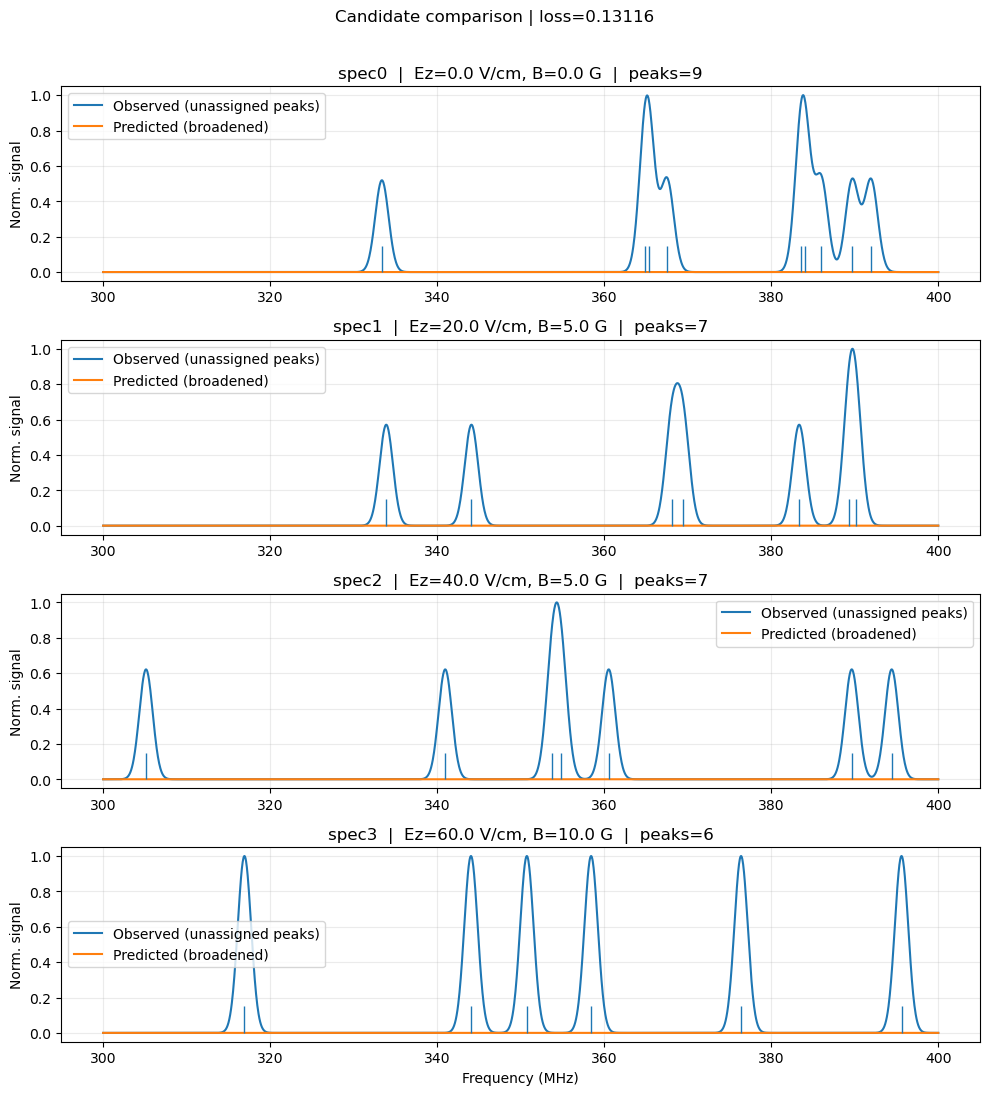

this function only calculates transitions connecting same parity states
specify laser_polarization from both, orth, para 
this function only calculates transitions connecting same parity states
specify laser_polarization from both, orth, para 
this function only calculates transitions connecting same parity states
specify laser_polarization from both, orth, para 
this function only calculates transitions connecting same parity states
specify laser_polarization from both, orth, para 
saved: candidate_02.png


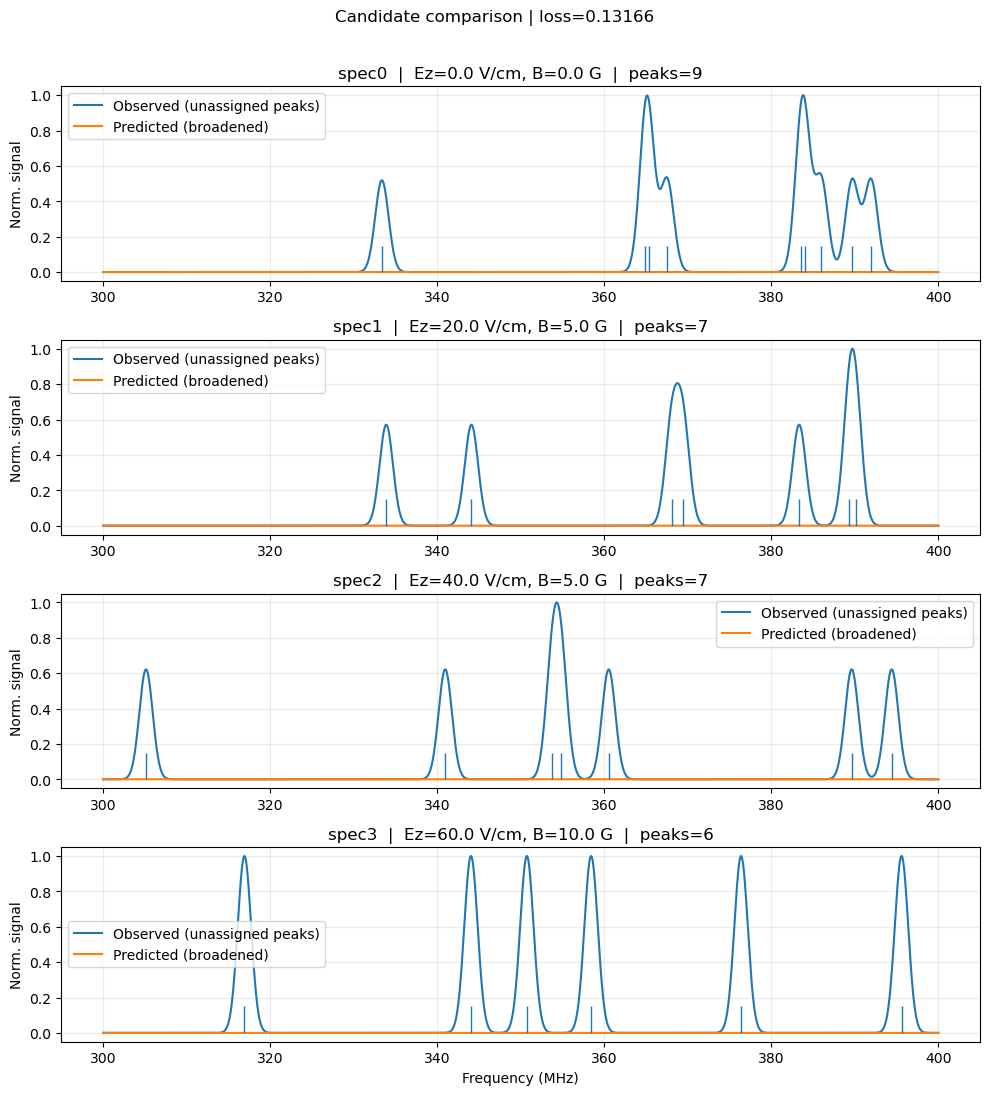

In [24]:
import matplotlib.pyplot as plt
import numpy as np

def plot_candidate_vs_data(state, candidate_row, spectra, indices=None,
                           sigma=UNASSIGNED_SIGMA, parity_sign=None, polarization=None,
                           window=None, save_prefix=None):
    """
    For one candidate (a dict-like row), apply params then plot obs vs pred for each spectrum.
    window: (fmin, fmax) or None -> auto from observed.
    """
    # apply candidate parameters
    cand = dict(candidate_row)
    cand.pop("loss", None)
    apply_params(state, cand)

    n = len(spectra)
    fig, axes = plt.subplots(n, 1, figsize=(10, 2.7*n), sharex=False)
    if n == 1:
        axes = [axes]

    for ax, s in zip(axes, spectra):
        obs = np.asarray(s["freqs"], float)
        pred_f, pred_w = transition_frequency_set_safe(
            state, Ez=s["Ez"], B=s["B"], indices=indices,
            parity_sign=parity_sign, polarization=polarization
        )
        pred_f = np.asarray(pred_f, float)
        pred_w = np.asarray(pred_w, float) if pred_w is not None else np.ones_like(pred_f, float)

        if window is None:
            if obs.size:
                fmin, fmax = obs.min() - 3*sigma, obs.max() + 3*sigma
            elif pred_f.size:
                fmin, fmax = pred_f.min() - 3*sigma, pred_f.max() + 3*sigma
            else:
                fmin, fmax = 0.0, 1.0
        else:
            fmin, fmax = window

        axis = np.linspace(fmin, fmax, 2000)
        pred_spec = gaussian_broadened_spectrum(pred_f, pred_w, axis, sigma)
        obs_spec  = gaussian_broadened_spectrum(obs, np.ones_like(obs), axis, sigma)

        # normalize
        pred_spec = pred_spec / (pred_spec.max() if pred_spec.max() else 1.0)
        obs_spec  = obs_spec  / (obs_spec.max()  if obs_spec.max()  else 1.0)

        ax.plot(axis, obs_spec, label="Observed (unassigned peaks)")
        ax.plot(axis, pred_spec, label="Predicted (broadened)")
        if obs.size:
            ax.vlines(obs, 0.0, 0.15, linewidth=1)
        ax.set_ylabel("Norm. signal")
        ax.set_title(f"{s['id']}  |  Ez={s['Ez']} V/cm, B={s['B']} G  |  peaks={obs.size}")

        ax.grid(True, alpha=0.25)
        ax.legend()

    axes[-1].set_xlabel("Frequency (MHz)")
    loss = candidate_row["loss"] if isinstance(candidate_row, dict) and "loss" in candidate_row else None
    fig.suptitle(f"Candidate comparison" + (f" | loss={loss:.5f}" if loss is not None else ""), y=1.01)
    fig.tight_layout()

    if save_prefix is not None:
        out = f"{save_prefix}.png"
        fig.savefig(out, dpi=200, bbox_inches="tight")
        print("saved:", out)

    plt.show()

# ---- PLOT TOP CANDIDATES ----
for i, row in enumerate(best_list, 1):
    plot_candidate_vs_data(
        X010_173,
        row,
        OBS_SPECTRA,
        indices=None,  # or TRANSITION_INDEX_SET
        sigma=UNASSIGNED_SIGMA,
        parity_sign=PARITY_SIGN,
        polarization=LASER_POLARIZATION,
        window=(300.0, 400.0),           # set your window; or None for auto
        save_prefix=f"candidate_{i:02d}"
    )


In [8]:
def gaussian_broadened_spectrum(frequencies, weights=None, freq_axis=None, sigma=UNASSIGNED_SIGMA):
    if freq_axis is None:
        if frequencies.size == 0:
            return np.linspace(0, 1, 1000), np.zeros(1000)
        f_min, f_max = frequencies.min() - 3 * sigma, frequencies.max() + 3 * sigma
        freq_axis = np.linspace(f_min, f_max, 2000)
    if weights is None:
        weights = np.ones_like(frequencies)
    if frequencies.size == 0:
        return freq_axis, np.zeros_like(freq_axis)
    diff = freq_axis[:, None] - frequencies[None, :]
    spectrum = np.exp(-(diff**2) / (2 * sigma**2)) @ weights
    return freq_axis, spectrum


def spectral_residual(predicted_freqs, observed_freqs, predicted_weights=None, observed_weights=None, sigma=UNASSIGNED_SIGMA):
    if observed_freqs.size == 0 or predicted_freqs.size == 0:
        return np.inf
    freq_axis, observed_spec = gaussian_broadened_spectrum(observed_freqs, observed_weights, sigma=sigma)
    _, predicted_spec = gaussian_broadened_spectrum(predicted_freqs, predicted_weights, freq_axis=freq_axis, sigma=sigma)
    observed_spec /= observed_spec.max() if observed_spec.max() else 1
    predicted_spec /= predicted_spec.max() if predicted_spec.max() else 1
    return np.sqrt(np.mean((predicted_spec - observed_spec) ** 2))


def transition_frequency_set(state, Ez=EZ_FIELD, B=B_FIELD, indices=None, **kwargs):
    transitions, raw = compute_model_transitions(state, Ez=Ez, B=B, indices=indices, **kwargs)
    if transitions.empty:
        return np.array([]), np.array([]), raw
    weights = None
    for candidate in ["intensity", "Intensity", "strength", "Strength"]:
        if candidate in transitions.columns:
            weights = transitions[candidate].to_numpy()
            break
    return transitions["freq_model"].to_numpy(), weights, raw


def unassigned_spectrum_loss(state, Ez=EZ_FIELD, B=B_FIELD, sigma=UNASSIGNED_SIGMA, observed_freqs=None, observed_weights=None, **kwargs):
    if observed_freqs is None:
        observed_freqs = observed_unassigned_freqs
    if observed_weights is None:
        observed_weights = observed_unassigned_weights
    predicted_freqs, predicted_weights, _ = transition_frequency_set(state, Ez=Ez, B=B, **kwargs)
    return spectral_residual(predicted_freqs, observed_freqs, predicted_weights, observed_weights, sigma=sigma)


NameError: name 'EZ_FIELD' is not defined

In [9]:
# Parameter space exploration for unassigned spectra
UNASSIGNED_PARAMETER_NAMES = FIT_PARAMETER_NAMES  # Override to restrict search
UNASSIGNED_PARAMETER_BOUNDS = {name: FIT_PARAMETER_BOUNDS[name] for name in UNASSIGNED_PARAMETER_NAMES}
UNASSIGNED_RANDOM_SAMPLES = 100
UNASSIGNED_TOP_K = 10
USE_GAUSSIAN_PROCESS = True  # Toggle Bayesian surrogate refinement


def sample_parameter_vector(bounds_dict):
    return np.array([
        np.random.uniform(low=low, high=high) for (low, high) in bounds_dict.values()
    ])


def evaluate_parameter_vector(param_vector, state=None, observed_freqs=None, observed_weights=None):
    state = state or X010_173
    updates = parameter_vector_to_dict(param_vector)
    set_state_parameters(state, updates)
    loss = unassigned_spectrum_loss(
        state,
        observed_freqs=observed_freqs,
        observed_weights=observed_weights,
    )
    return loss


def random_explore_unassigned(state, n_samples=UNASSIGNED_RANDOM_SAMPLES, bounds=None, observed_freqs=None, observed_weights=None):
    bounds = bounds or UNASSIGNED_PARAMETER_BOUNDS
    names = list(bounds.keys())
    samples = []
    for _ in range(n_samples):
        vec = sample_parameter_vector(bounds)
        loss = evaluate_parameter_vector(vec, state=state, observed_freqs=observed_freqs, observed_weights=observed_weights)
        samples.append({"params": parameter_vector_to_dict(vec), "vector": vec, "loss": loss})
    samples.sort(key=lambda x: x["loss"])
    return names, samples


random_search_results = None
if observed_unassigned_freqs.size:
    names, random_search_results = random_explore_unassigned(
        X010_173,
        n_samples=UNASSIGNED_RANDOM_SAMPLES,
        bounds=UNASSIGNED_PARAMETER_BOUNDS,
        observed_freqs=observed_unassigned_freqs,
        observed_weights=observed_unassigned_weights,
    )
    best_candidates = random_search_results[:UNASSIGNED_TOP_K]
    print("Top random-search candidates (loss is spectrum RMSE):")
    for idx, candidate in enumerate(best_candidates, 1):
        print(f"#{idx}: loss={candidate['loss']:.5f}")
else:
    print("No unassigned data loaded; skipping random exploration.")


surrogate_model = None
surrogate_history = []

if USE_GAUSSIAN_PROCESS and observed_unassigned_freqs.size and random_search_results:
    try:
        from sklearn.gaussian_process import GaussianProcessRegressor
        from sklearn.gaussian_process.kernels import Matern, WhiteKernel
        from sklearn.preprocessing import StandardScaler

        kernel = Matern(length_scale=np.ones(len(names)), nu=2.5) + WhiteKernel(noise_level=1e-6)
        gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True, n_restarts_optimizer=3)
        scaler = StandardScaler()

        X_samples = np.array([entry["vector"] for entry in random_search_results])
        y_samples = np.array([entry["loss"] for entry in random_search_results])
        scaler.fit(X_samples)
        gp.fit(scaler.transform(X_samples), y_samples)

        surrogate_model = {"gp": gp, "scaler": scaler, "names": names}

        def propose_next(gp_model, n_candidates=512):
            raw = np.array([sample_parameter_vector(UNASSIGNED_PARAMETER_BOUNDS) for _ in range(n_candidates)])
            mu, sigma = gp_model["gp"].predict(gp_model["scaler"].transform(raw), return_std=True)
            acquisition = mu - 1.96 * sigma  # Lower Confidence Bound
            best_idx = np.argmin(acquisition)
            return raw[best_idx], acquisition[best_idx]

        for iteration in range(10):
            candidate_vec, acquisition_value = propose_next(surrogate_model)
            candidate_loss = evaluate_parameter_vector(
                candidate_vec,
                state=X010_173,
                observed_freqs=observed_unassigned_freqs,
                observed_weights=observed_unassigned_weights,
            )
            surrogate_history.append({
                "vector": candidate_vec,
                "params": parameter_vector_to_dict(candidate_vec),
                "loss": candidate_loss,
                "acquisition": acquisition_value,
            })
            # Update GP with new observation
            X_samples = np.vstack([X_samples, candidate_vec])
            y_samples = np.append(y_samples, candidate_loss)
            scaler.fit(X_samples)
            gp.fit(scaler.transform(X_samples), y_samples)

        print(f"Gaussian-process refinement completed with {len(surrogate_history)} additional evaluations.")
    except ImportError:
        print("scikit-learn not available; skipping Gaussian-process refinement.")


NameError: name 'unassigned_spectrum_loss' is not defined

In [ ]:
def collect_candidate_table(random_results=None, surrogate_results=None, top_k=UNASSIGNED_TOP_K):
    records = []
    for source, entries in [("random", random_results or []), ("gp", surrogate_results or [])]:
        for entry in (entries if isinstance(entries, list) else []):
            row = {"source": source, "loss": entry["loss"], **entry.get("params", {})}
            records.append(row)
    if not records:
        return pd.DataFrame()
    df = pd.DataFrame(records)
    df = df.sort_values("loss").head(top_k).reset_index(drop=True)
    return df


candidate_table = collect_candidate_table(
    random_results=random_search_results,
    surrogate_results=surrogate_history,
)

if not candidate_table.empty:
    display(candidate_table)
else:
    print("No parameter candidates generated yet.")


In [ ]:
def plot_spectrum_comparison(candidate_params, observed_freqs=None, observed_weights=None, sigma=UNASSIGNED_SIGMA, title_suffix=""):
    observed_freqs = observed_freqs if observed_freqs is not None else observed_unassigned_freqs
    observed_weights = observed_weights if observed_weights is not None else observed_unassigned_weights
    if observed_freqs.size == 0:
        print("No unassigned frequencies to visualize.")
        return
    set_state_parameters(X010_173, candidate_params)
    predicted_freqs, predicted_weights, _ = transition_frequency_set(X010_173)
    freq_axis, observed_spec = gaussian_broadened_spectrum(observed_freqs, observed_weights, sigma=sigma)
    _, predicted_spec = gaussian_broadened_spectrum(predicted_freqs, predicted_weights, freq_axis=freq_axis, sigma=sigma)
    observed_spec /= observed_spec.max() if observed_spec.max() else 1
    predicted_spec /= predicted_spec.max() if predicted_spec.max() else 1
    plt.figure(figsize=(12, 5))
    plt.plot(freq_axis, observed_spec, label="Observed", lw=2)
    plt.plot(freq_axis, predicted_spec, label="Predicted", lw=2)
    plt.xlabel("Frequency (MHz)")
    plt.ylabel("Normalized intensity")
    plt.title(f"Spectrum overlay {title_suffix}")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()


if candidate_table.shape[0]:
    best_candidate_params = candidate_table.iloc[0].drop(labels=["source", "loss"]).to_dict()
    print("Plotting spectrum overlay for top candidate...")
    plot_spectrum_comparison(best_candidate_params, title_suffix=f"loss={candidate_table.iloc[0]['loss']:.4f}")
